In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# Masked Softmax

In [3]:
# Masking just means we're telling the computer to pay zero attention to certain tokens. 
# Therefore, it is not applied during the data processing stage but during the attention layer, where the attention weights are calculated.

# X: 3D tensor, valid_lens: 1D or 2D tensor
# Shape of valid_lens: (batch_size,) or (batch_size, #of queries)
def masked_softmax(X, valid_lens):
    
    def _sequence_mask(X, valid_len, value=0):
        # X: 2D tensor, valid_len: 1D tensor
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    
    if valid_lens is None:
        return nn.functional.softmax(X, dim = -1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
       

        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        print("Valid_lens: ", valid_lens)
        print("X after sequence mask: \n", X)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
        

In [4]:
y = torch.tensor([[1, 2], [3, 4]])
y

tensor([[1, 2],
        [3, 4]])

In [5]:
torch.repeat_interleave(y, 1)

tensor([1, 2, 3, 4])

In [6]:
X = torch.rand(2, 2, 4)
torch.arange(X.size(1), dtype=torch.float32)[None, :]

tensor([[0., 1.]])

In [7]:
print(X)
# the valid length for the first pair (2x4) is 2, and 3 for the second pair (also 2x4).
# so both the elements of the first pairs will be truncated to 2, and 3 for the elements of the second pair.
masked_softmax(X, torch.tensor([2, 3]))

tensor([[[0.6482, 0.3709, 0.7555, 0.9031],
         [0.0445, 0.9022, 0.5051, 0.4711]],

        [[0.7972, 0.8412, 0.2627, 0.0858],
         [0.6220, 0.5146, 0.0140, 0.8553]]])
Valid_lens:  tensor([2, 2, 3, 3])
X after sequence mask: 
 tensor([[ 6.4820e-01,  3.7091e-01, -1.0000e+06, -1.0000e+06],
        [ 4.4494e-02,  9.0218e-01, -1.0000e+06, -1.0000e+06],
        [ 7.9725e-01,  8.4116e-01,  2.6269e-01, -1.0000e+06],
        [ 6.2195e-01,  5.1457e-01,  1.4002e-02, -1.0000e+06]])


tensor([[[0.5689, 0.4311, 0.0000, 0.0000],
         [0.2978, 0.7022, 0.0000, 0.0000]],

        [[0.3801, 0.3972, 0.2227, 0.0000],
         [0.4094, 0.3677, 0.2229, 0.0000]]])

In [8]:
print(X)
X.reshape(-1, X.shape[-1])

tensor([[[ 6.4820e-01,  3.7091e-01, -1.0000e+06, -1.0000e+06],
         [ 4.4494e-02,  9.0218e-01, -1.0000e+06, -1.0000e+06]],

        [[ 7.9725e-01,  8.4116e-01,  2.6269e-01, -1.0000e+06],
         [ 6.2195e-01,  5.1457e-01,  1.4002e-02, -1.0000e+06]]])


tensor([[ 6.4820e-01,  3.7091e-01, -1.0000e+06, -1.0000e+06],
        [ 4.4494e-02,  9.0218e-01, -1.0000e+06, -1.0000e+06],
        [ 7.9725e-01,  8.4116e-01,  2.6269e-01, -1.0000e+06],
        [ 6.2195e-01,  5.1457e-01,  1.4002e-02, -1.0000e+06]])

In [9]:
masked_softmax(X, torch.tensor([[1, 2], [3, 4]]))

Valid_lens:  tensor([1, 2, 3, 4])
X after sequence mask: 
 tensor([[ 6.4820e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [ 4.4494e-02,  9.0218e-01, -1.0000e+06, -1.0000e+06],
        [ 7.9725e-01,  8.4116e-01,  2.6269e-01, -1.0000e+06],
        [ 6.2195e-01,  5.1457e-01,  1.4002e-02, -1.0000e+06]])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2978, 0.7022, 0.0000, 0.0000]],

        [[0.3801, 0.3972, 0.2227, 0.0000],
         [0.4094, 0.3677, 0.2229, 0.0000]]])

# Scaled Dot Product Multiplication

In practice, we often think of minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot product attention 
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as 

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`


In [10]:
class DotProductAttention(nn.Module): #@save
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    
    # Shape of queries: (batch_size, #of queries, d)
    # Shape of keys: (batch_size, #of key-value pairs, d)
    # Shape of values: (batch_size, #of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, #of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]

        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [11]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))


Valid_lens:  tensor([2, 6])
X after sequence mask: 
 tensor([[-1.3326e+00, -1.6612e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [-1.0463e+00,  1.0653e+00, -4.2951e-01, -3.8052e-01,  8.2440e-01,
          1.1190e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]])


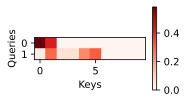

In [12]:
# Let’s check whether the attention weights actually vanish for anything beyond the second and sixth column respectively (because of setting the valid length to and ).
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


## Testing broadcasting in matrix multiplication

bascially it will broadcast until we reach the last 2 dimensions, where it will then perform a matrix-matrix multiplication

In [13]:
x = torch.tensor(
[
  [
    [
      [1, 2],
      [3, 4]
    ]
  ],
  [
    [
      [5, 6],
      [7, 8]
    ]
  ]
])

y = torch.tensor(
[
  [
    [1, 0],
    [0, 1]
  ],
  [
    [2, 0],
    [0, 2]
  ],
  [
    [1, 1],
    [1, 1]
  ]
])


In [14]:
print(x.shape)
print(y.shape)

torch.Size([2, 1, 2, 2])
torch.Size([3, 2, 2])


In [15]:
z = torch.matmul(x, y)
z.shape

torch.Size([2, 3, 2, 2])

In [16]:
z

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 2,  4],
          [ 6,  8]],

         [[ 3,  3],
          [ 7,  7]]],


        [[[ 5,  6],
          [ 7,  8]],

         [[10, 12],
          [14, 16]],

         [[11, 11],
          [15, 15]]]])

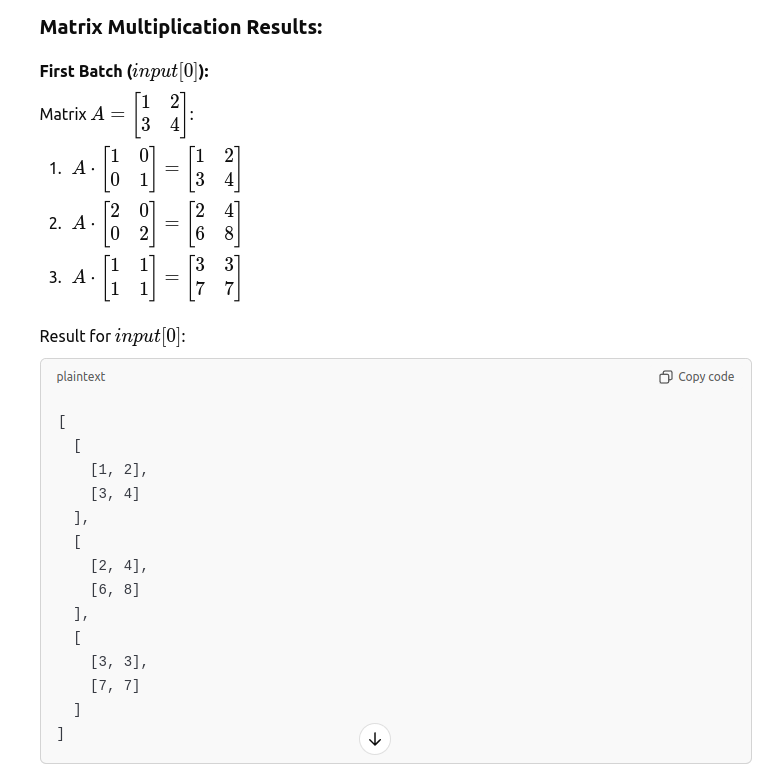

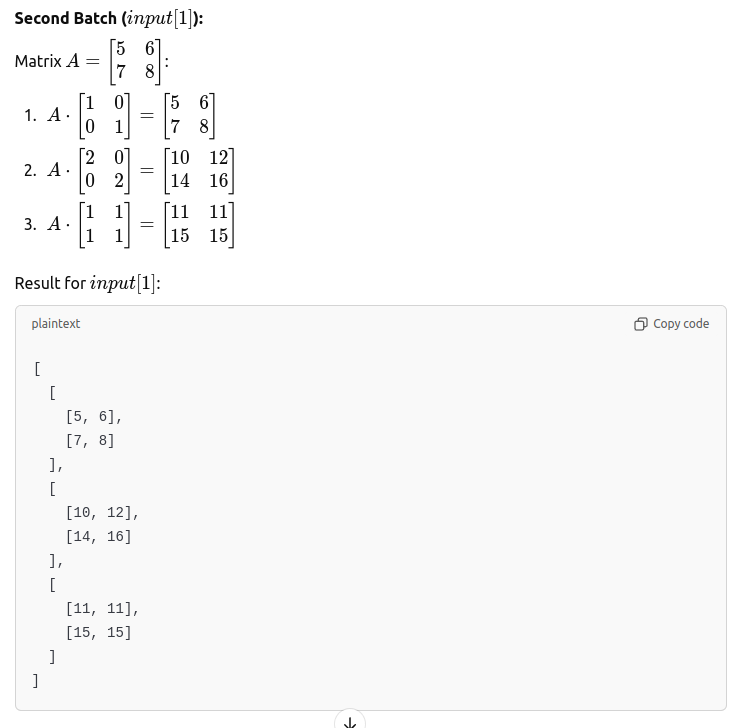


In [17]:
# Final result:

result = torch.tensor(
[
  [
    [
      [1, 2],
      [3, 4]
    ],
    [
      [2, 4],
      [6, 8]
    ],
    [
      [3, 3],
      [7, 7]
    ]
  ],
  [
    [
      [5, 6],
      [7, 8]
    ],
    [
      [10, 12],
      [14, 16]
    ],
    [
      [11, 11],
      [15, 15]
    ]
  ]
])


In [18]:
a = torch.tensor([3, 5])

# Multihead Attention

MUST WATCH from 3B1B: https://www.youtube.com/watch?v=eMlx5fFNoYc&t=400s

Lots of good diagrams in this article: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853


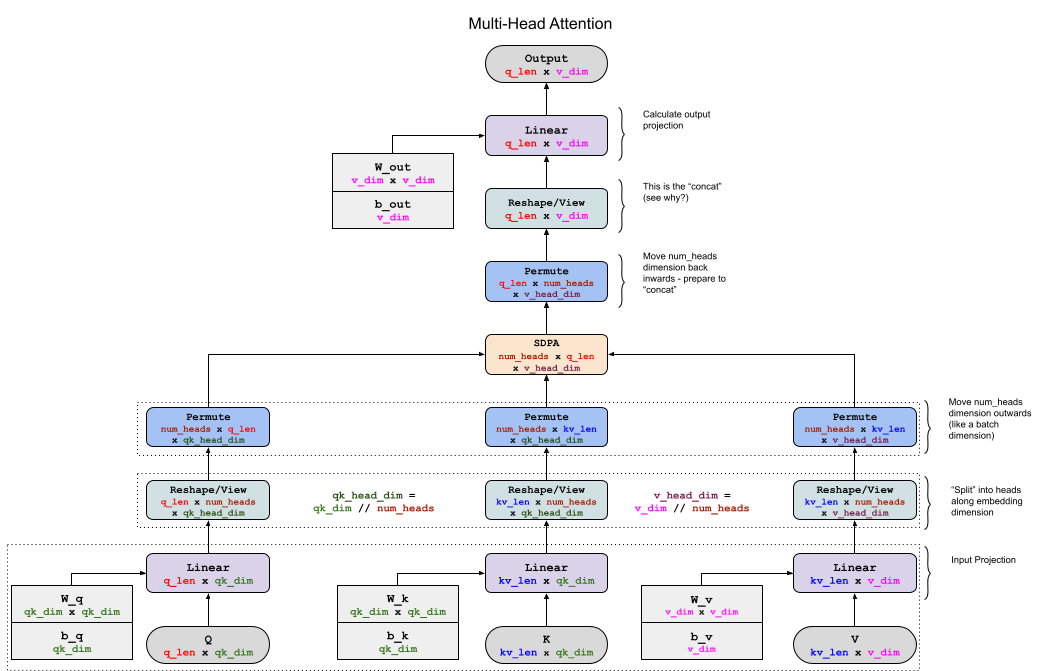

In [19]:
debug = True

In [20]:
# Masking just means we're telling the computer to pay zero attention to certain tokens. 
# Therefore, it is not applied during the data processing stage but during the attention layer, where the attention weights are calculated.

# X: 3D tensor, valid_lens: 1D or 2D tensor
# Shape of valid_lens: (batch_size,) or (batch_size, #of queries)
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

        

class DotProductAttention(nn.Module): #@save
    """Scaled Dot Product Attention"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    # Shape of queries: (batch_size, #  queries, d)
    # Shape of keys: (batch_size, #  key-value pairs, d)
    # Shape of values: (batch_size, #  key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, #  queries)
    def forward(self, queries, keys, values, valid_lens):
        d = queries.shape[-1]
        # for each query in a batch, we want its dot product score against ALL the keys
        # so we gotta do (batch_size, #  queries, d) @ (batch_size, d, #  key-value pairs)
        # Shape of scores: (batch_size, #  queries, #  key_value pairs)
        scores = torch.bmm(queries, keys.transpose(1, 2) / math.sqrt(d))
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of return: (batch_size, #  queries, value dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)
    

In [21]:
class AttentionDecoder(d2l.Decoder): #@save
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError


In [22]:
class MultiHeadAttention(d2l.Module):
    """In the Transformer architecture, any time `# of queries` is mentioned below, 
    it is also equivalent to the sequence length.
    """
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.num_hiddens = num_hiddens
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of transposed X: (batch_size*num_heads, # queries OR # key-value pairs, num_hiddens/num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if debug:
            print("[DEBUG] MultiHeadAttention queries' shape: ", queries.shape)
            print("[DEBUG] MultiHeadAttention keys' shape: ", keys.shape)
            print("[DEBUG] MultiHeadAttention values' shape: ", values.shape)

                    
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size, # queries, dim of `v` which is num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        if debug:
            print("[DEBUG] MultiHeadAttention output's shape: ", output.shape)
        output_concat = self.transpose_output(output) 
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
        # Shape of input X: (batch_size, # queries OR # key-value pairs, num_hiddens)
        # Shape of reshaped X: (batch_size, # queries OR # key-value pairs, num_heads, num_hiddens/num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of permuted X: (batch_size, num_heads, # queries OR # key-value pairs, num_hiddens/num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of permuted X: (batch_size*num_heads, # queries OR # key-value pairs, num_hiddens/num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of `transpose_qkv`"""
        # Shape of input X: (batch_size*num_heads, # queries, value dimension = num_hiddens/num_heads)
        # Shape of X: (batch_size, num_heads, # queries, value dimension)
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        # Shape of output X: (batch_size, # queries, num_heads, value dimension = num_hiddens/num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output X: (batch_size, # queries, num_heads, num_hiddens)
        return X.reshape(X.shape[0], X.shape[1], -1)
    


In [23]:
num_hiddens, num_heads = 32, 4
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])

attention_layer = MultiHeadAttention(num_hiddens, num_heads, 0.2)
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention_layer(X, Y, Y, valid_lens)
d2l.check_shape(attention_layer(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))

[DEBUG] MultiHeadAttention queries' shape:  torch.Size([8, 4, 8])
[DEBUG] MultiHeadAttention keys' shape:  torch.Size([8, 6, 8])
[DEBUG] MultiHeadAttention values' shape:  torch.Size([8, 6, 8])
[DEBUG] MultiHeadAttention output's shape:  torch.Size([8, 4, 8])
[DEBUG] MultiHeadAttention queries' shape:  torch.Size([8, 4, 8])
[DEBUG] MultiHeadAttention keys' shape:  torch.Size([8, 6, 8])
[DEBUG] MultiHeadAttention values' shape:  torch.Size([8, 6, 8])
[DEBUG] MultiHeadAttention output's shape:  torch.Size([8, 4, 8])


In [25]:
#print(attention_layer.attention.attention_weights)
#print(d2l.show_heatmaps.__code__.co_varnames)
#d2l.show_heatmaps(attention_layer.attention.attention_weights.reshape(batch_size, num_heads, num_queries, num_kvpairs), "x", "y")

## [**Positional Encoding**]
:label:`subsec_positional-encoding`


Unlike RNNs, which recurrently process
tokens of a sequence one-by-one,
self-attention ditches
sequential operations in favor of 
parallel computation.
Note that self-attention by itself
does not preserve the order of the sequence. 
What do we do if it really matters 
that the model knows in which order
the input sequence arrived?

We will use a **fixed** positional encoding - fixed here means it is **initialized once** and is **NOT changed during both training and inference**

Suppose that the input representation 
$\mathbf{X} \in \mathbb{R}^{n \times d}$ 
contains the $d$-dimensional embeddings 
for $n$ tokens of a sequence.
The positional encoding outputs
$\mathbf{X} + \mathbf{P}$
using a positional embedding matrix 
$\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape,
whose element on the $i^\textrm{th}$ row 
and the $(2j)^\textrm{th}$
or the $(2j + 1)^\textrm{th}$ column is

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$
:eqlabel:`eq_positional-encoding-def`


In [70]:
class PositionalEncoding(nn.Module): #@save
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P, shape of P: (max sequence length, input embeddings dim = num_hiddens)
        self.P = torch.zeros((1, max_len, num_hiddens))
        # initialize the positional encoding
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        # 0::2 in the third dimension means "select every second element starting from index 0."
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        # make sure the second dim matches
        X = X + self.P[:, X.shape[1], :].to(X.device)
        return self.dropout(X)

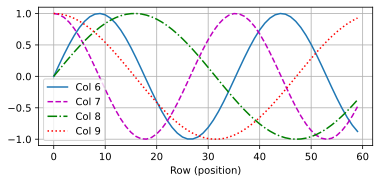

In [68]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
# the 6th and 7th columns have a higher freq then the col 8 and 9. 
# the offset between col 6 and 7 (and between 8 and 9) is due to even cols use sin, while odd cols use cos
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In binary representations, a higher bit has a lower frequency than a lower bit. Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. 

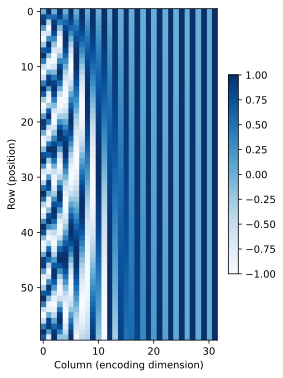

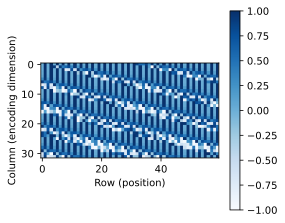

In [69]:
# run the above code block before this block as we changed P's dimension here.
P2 = P[:, :, :].unsqueeze(0).reshape(1, -1, P.shape[2], P.shape[1])
P = P[:, :, :].unsqueeze(0)

d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(4, 6), cmap='Blues')
d2l.show_heatmaps(P2, xlabel='Row (position)',
                  ylabel='Column (encoding dimension)', figsize=(4, 6), cmap='Blues')

# Relative Positional Information

Besides capturing absolute positional information,
the above positional encoding
also allows
a model to easily learn to attend by relative positions.
This is because
for any fixed position offset $\delta$,
the positional encoding at position $i + \delta$
can be represented by a linear projection
of that at position $i$.


This projection can be explained
mathematically.
Denoting
$\omega_j = 1/10000^{2j/d}$,
any pair of $(p_{i, 2j}, p_{i, 2j+1})$ 
in :eqref:`eq_positional-encoding-def`
can 
be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$
for any fixed offset $\delta$:

$$\begin{aligned}
\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $i$.